In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff

Loading and Merging Dataset Function

In [2]:
def load_arff_dataset(path):
    data, meta = arff.loadarff(path)
    df = pd.DataFrame(data)
    if 'class' in df.columns and df['class'].dtype == object:
        df['class'] = df['class'].apply(lambda x: x.decode('utf-8'))
    return df

In [3]:
files = ["1year.arff", "2year.arff", "3year.arff", "4year.arff", "5year.arff"]
frames = [load_arff_dataset(file) for file in files]
df = pd.concat(frames, ignore_index=True)
print("Original Shape:", df.shape)

Original Shape: (43405, 65)


Analysing Dataset

In [4]:
print(df['class'].value_counts())
print("Missing values:", df.isnull().sum().sum())

class
0    41314
1     2091
Name: count, dtype: int64
Missing values: 41322


Dealing with Missing Values

In [5]:
missing_ratio = df.isnull().mean() * 100
too_missing = missing_ratio[missing_ratio > 40].index
df.drop(columns=too_missing, inplace=True)
print("Shape after dropping:", df.shape)

Shape after dropping: (43405, 64)


Imputing Missing Values wth median values

In [6]:
df = df.fillna(df.median(numeric_only=True))
print("Missing after imputation:", df.isnull().sum().sum())

Missing after imputation: 0


Performng EDA

Feature Distribution

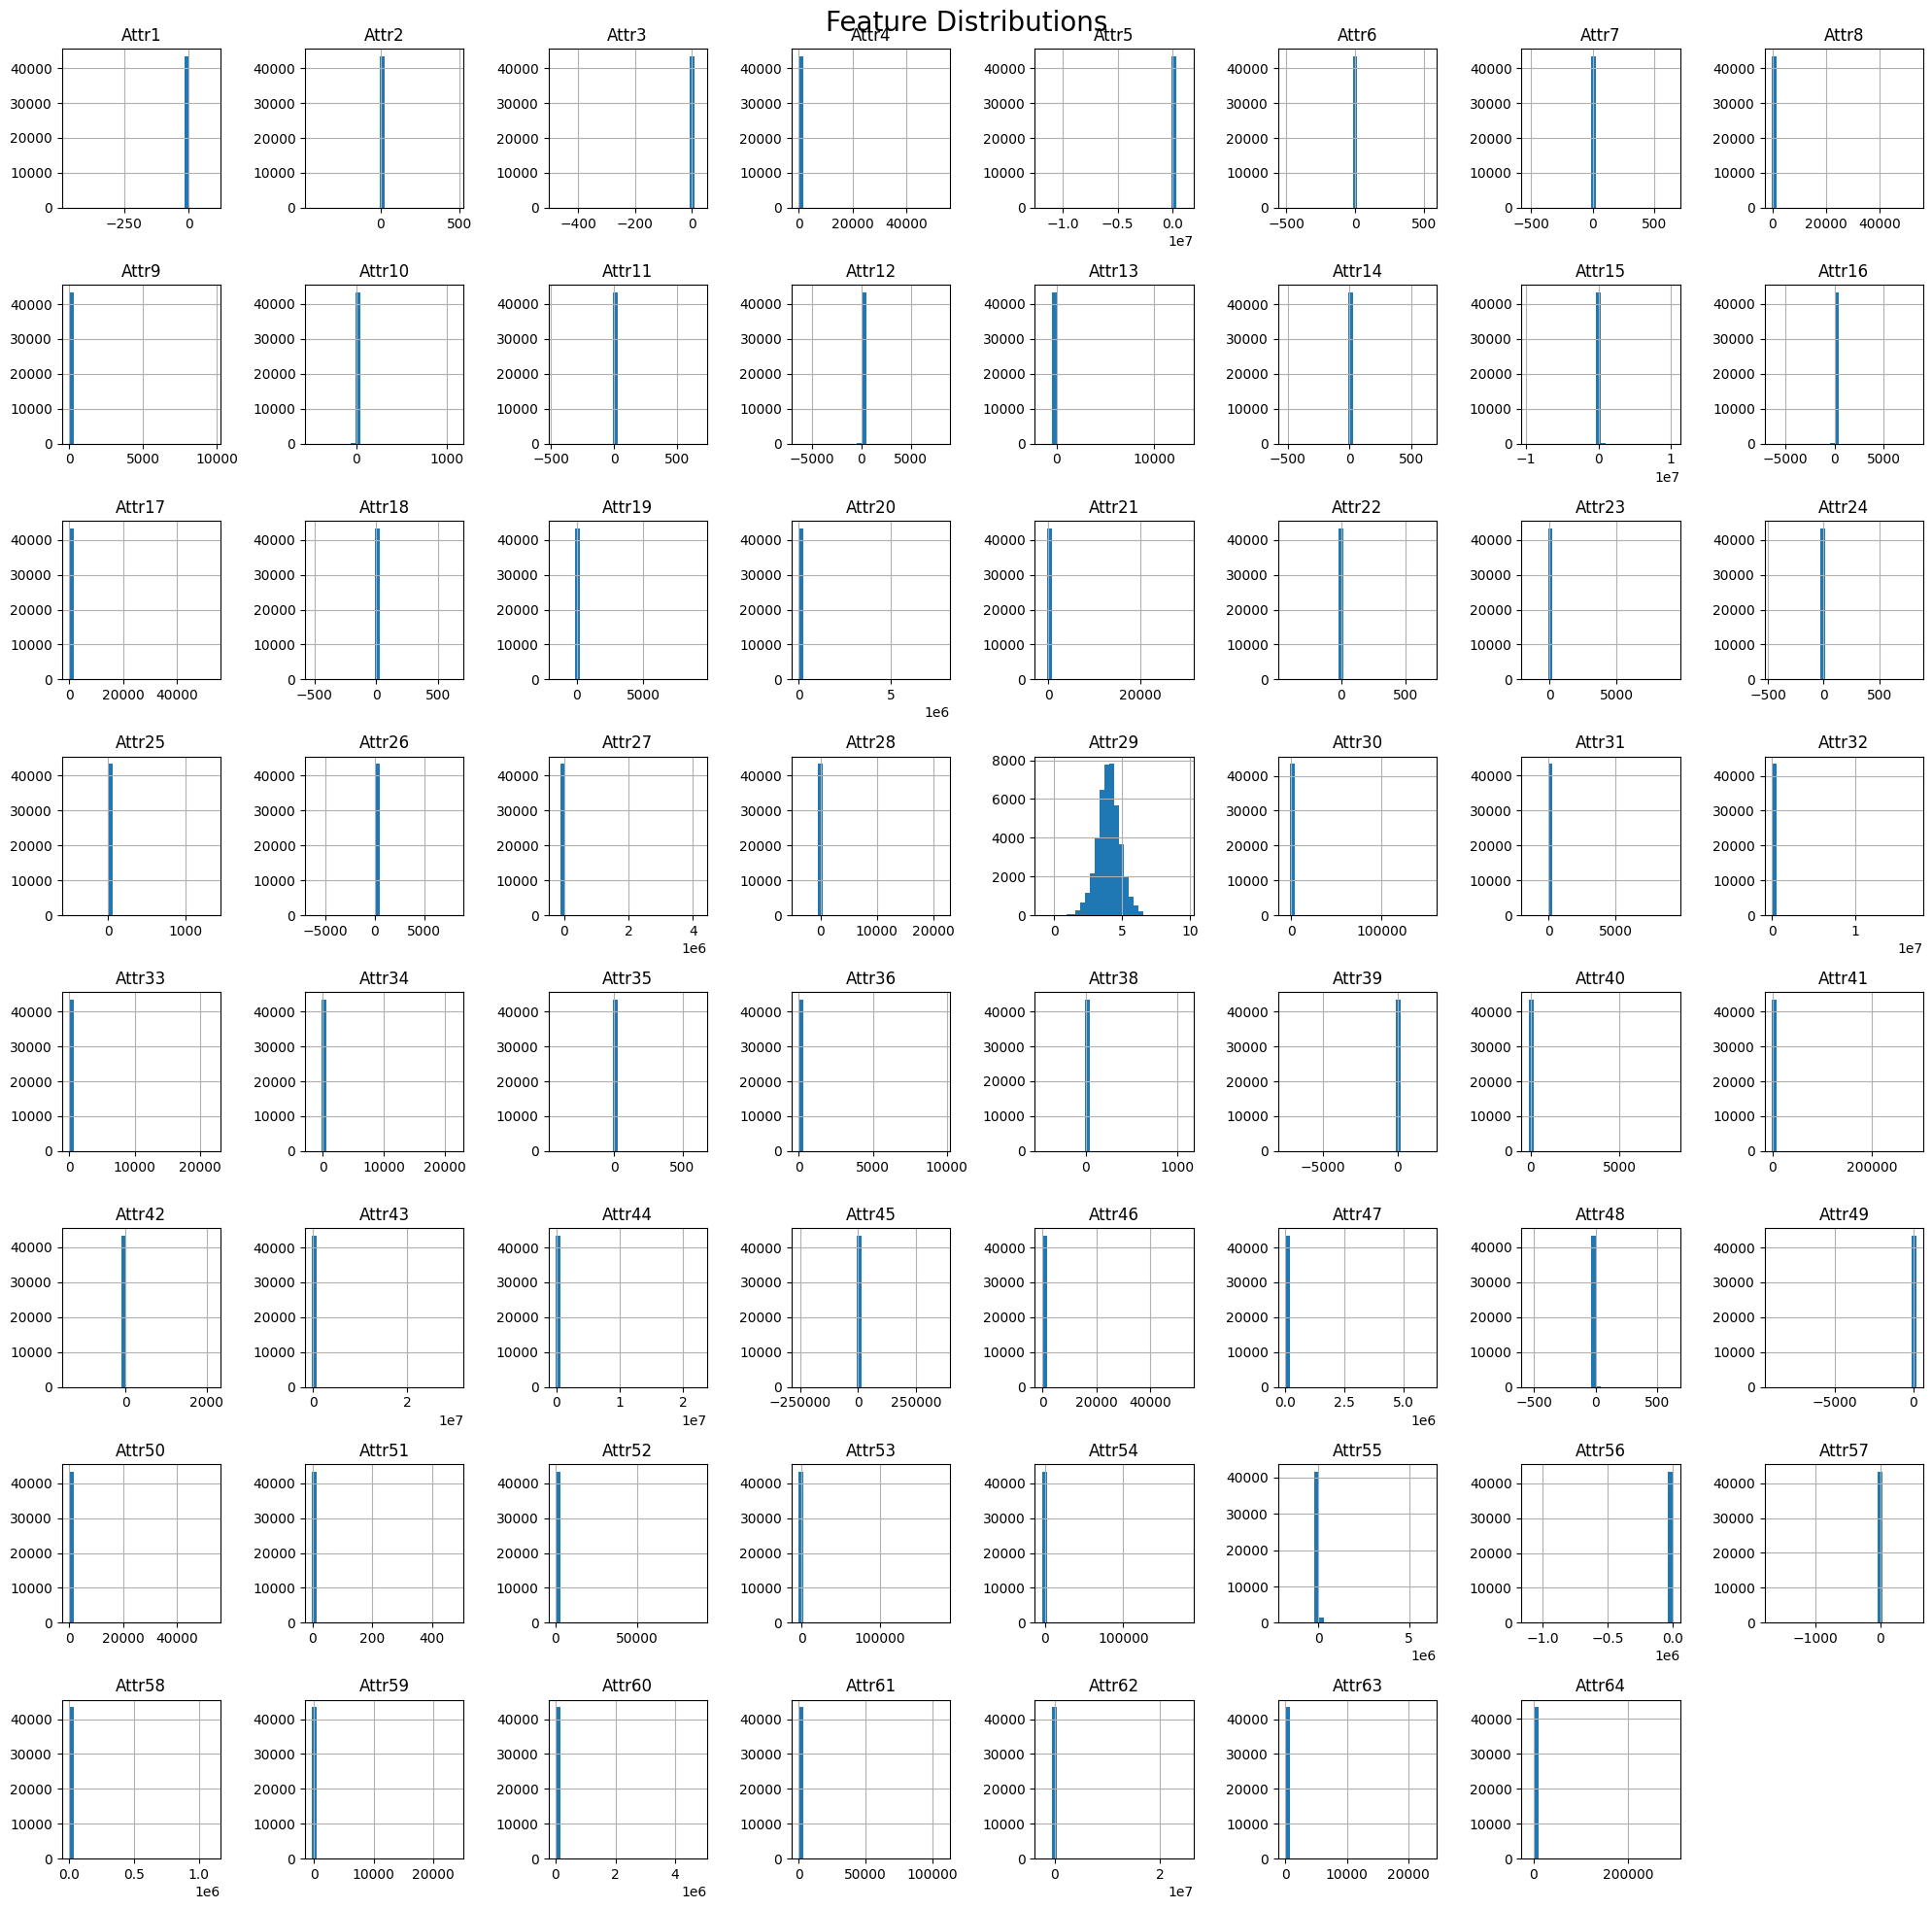

In [13]:
df.drop(columns=["class"]).hist(figsize=(20, 20), bins=30)
plt.suptitle("Feature Distributions", fontsize=20)
plt.tight_layout()
plt.show()


Coorelation Heatmap

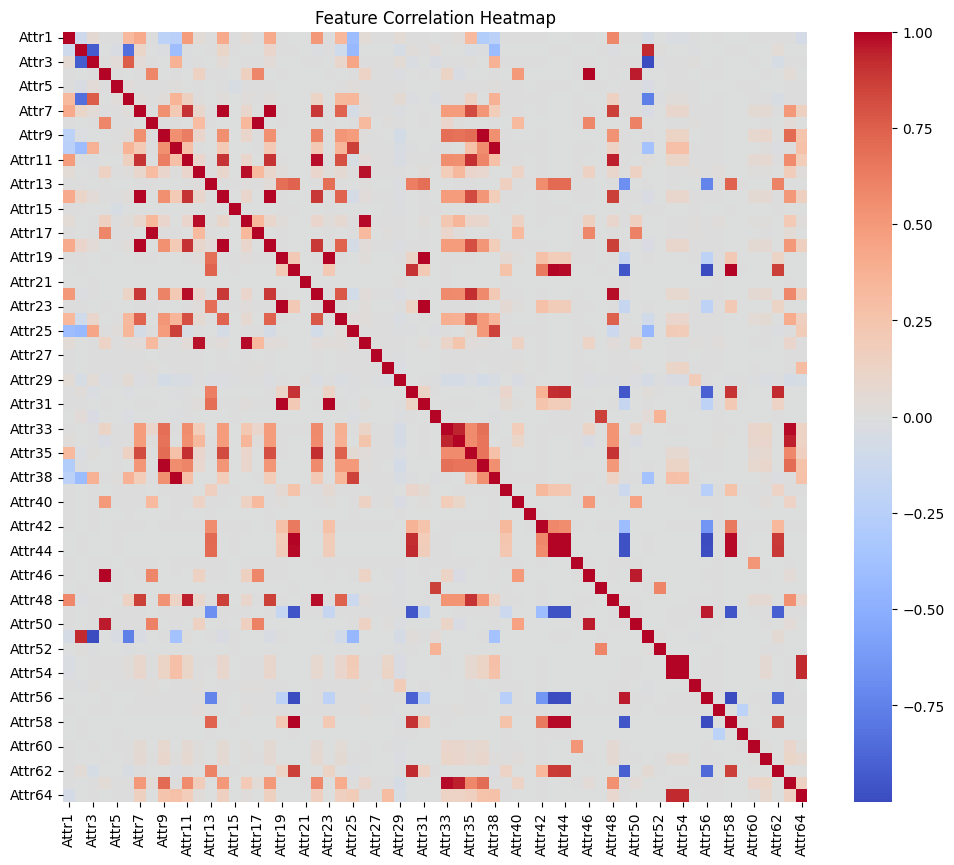

In [14]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.drop(columns=["class"]).corr(), cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

Principal Componenta Analysis

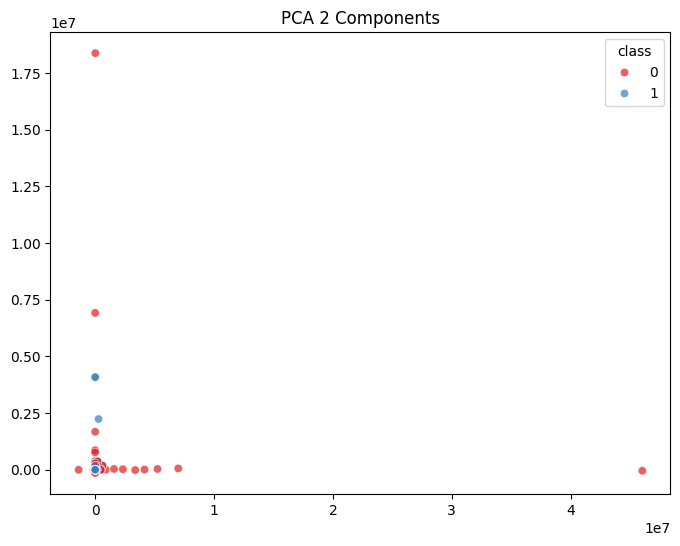

In [15]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
pca_result = pca.fit_transform(df.drop(columns="class"))
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df['class'], palette='Set1', alpha=0.7)
plt.title("PCA 2 Components")
plt.show()

Feature Scaling

In [18]:
from sklearn.preprocessing import StandardScaler


X = df.drop("class", axis=1)
y = df["class"].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Splitting Dataset into train / test splits

In [19]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

Handling Imbalance values

In [20]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_train_res).value_counts().to_dict())

Before SMOTE: {0: 33051, 1: 1673}
After SMOTE: {0: 33051, 1: 33051}


Model Training

In [22]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

Logistic Regression

In [23]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_res, y_train_res)
preds_logreg = logreg.predict(X_test)
print(confusion_matrix(y_test, preds_logreg))
print(classification_report(y_test, preds_logreg))
try:
    probs = logreg.predict_proba(X_test)[:, 1]
    print("ROC-AUC:", roc_auc_score(y_test, probs))
except:
    print("Probabilities not available")

[[6035 2228]
 [ 162  256]]
              precision    recall  f1-score   support

           0       0.97      0.73      0.83      8263
           1       0.10      0.61      0.18       418

    accuracy                           0.72      8681
   macro avg       0.54      0.67      0.51      8681
weighted avg       0.93      0.72      0.80      8681

ROC-AUC: 0.7321923348853799


Random Forest

In [24]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)
preds_rf = rf.predict(X_test)
print(confusion_matrix(y_test, preds_rf))
print(classification_report(y_test, preds_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

[[8070  193]
 [ 201  217]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8263
           1       0.53      0.52      0.52       418

    accuracy                           0.95      8681
   macro avg       0.75      0.75      0.75      8681
weighted avg       0.95      0.95      0.95      8681

ROC-AUC: 0.9271585675927797


XGBoost

In [25]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_res, y_train_res)
preds_xgb = xgb.predict(X_test)
print(confusion_matrix(y_test, preds_xgb))
print(classification_report(y_test, preds_xgb))
print("ROC-AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:15:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[8150  113]
 [ 129  289]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      8263
           1       0.72      0.69      0.70       418

    accuracy                           0.97      8681
   macro avg       0.85      0.84      0.85      8681
weighted avg       0.97      0.97      0.97      8681

ROC-AUC: 0.9621926765247976


Performing Cross Validation to check the model's performances

In [26]:
models = {
    "LogReg": logreg,
    "RandomForest": rf,
    "XGBoost": xgb,
}

print("\nStratified K-Fold Cross-validation (5-fold):")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    try:
        scores = cross_val_score(model, X_scaled, y, cv=skf, scoring='roc_auc')
        print(f"{name}: Mean AUC = {scores.mean():.4f}")
    except Exception as e:
        print(f"{name}: Cross-validation failed - {str(e)}")



Stratified K-Fold Cross-validation (5-fold):
LogReg: Mean AUC = 0.6705
RandomForest: Mean AUC = 0.9219


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:20:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:20:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:20:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:20:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:20:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost: Mean AUC = 0.9694


Feature Comparison

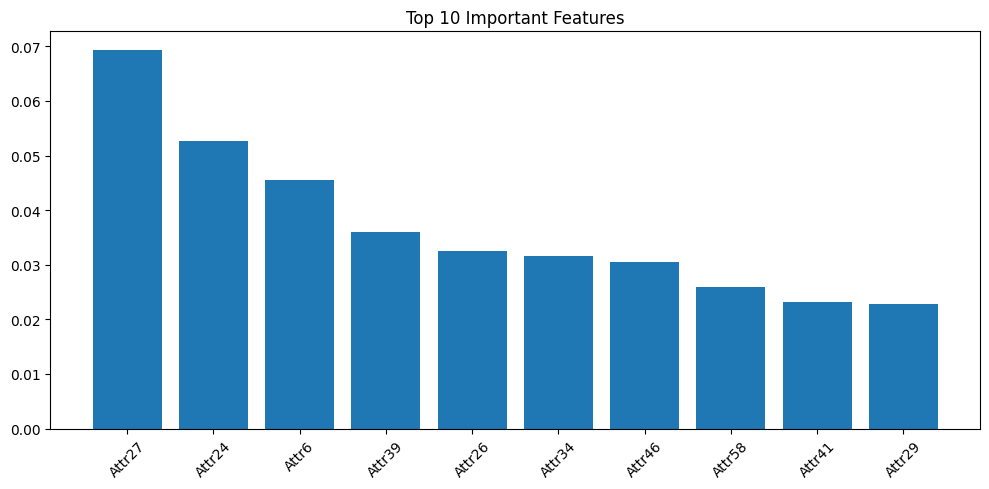

In [27]:
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:][::-1]
plt.figure(figsize=(10, 5))
plt.title("Top 10 Important Features")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), [X.columns[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

#Assessment Report

#Objective#
To develop a machine learning model that can predict whether a company is likely to go bankrupt based on its financial indicators collected over 5 years. The task is framed as a binary classification problem (0 = non-bankrupt, 1 = bankrupt).

#Problem-Solving Approach#
1. Understanding the Data
The dataset contains 64 numerical financial features per company for each year. After merging all yearly datasets, we noticed:

Class imbalance: Very few bankrupt companies compared to non-bankrupt ones

Missing data: Some features had significant missing values

2. Data Preprocessing
Dropped columns with more than 40% missing values

Imputed remaining missing values using the median (to handle outliers better)

Standardized all features using StandardScaler to normalize the range

Handled class imbalance using SMOTE, which oversamples the minority class (bankrupt) by synthetically generating new examples

3. Exploratory Data Analysis
Histograms showed that many features were skewed, which is common in financial data

Correlation heatmap helped understand redundancy and potential multicollinearity

Applied PCA to visualize class separability in a 2D space

#Model Selection#
*Logistic Regression*	algorithm for linear and binary classification problems. can be readily generalized to multiclass settings, which is known as multinomial logistic regression or softmax regression.

*Random Forest*	A random forest can be
considered as an ensemble of decision trees. The idea behind a random forest is to average multiple (deep) decision trees that individually suffer from high variance to build a more robust model that has a better generalization performance and is less susceptible to overfitting.

*XGBoost*	Often top performer for structured/tabular data; handles imbalance well. It is essentially a computationally efficient implementation
of the original gradient boost algorithm.


#Evaluation#
Train-Test Split (80/20 stratified) to ensure class balance

##Performance Metrics:##

Accuracy

Precision, Recall, F1-score (to handle imbalance)

ROC-AUC (for overall class separability)

Cross-Validation: Used StratifiedKFold to validate model robustness (5 folds)

#Model Results#
Logistic Regression gave good baseline performance but struggled with recall missed some bankruptcies

Random Forest performed better overall, especially in identifying bankrupt companies

XGBoost had the best ROC-AUC and balanced precision/recall, making it the top choice

#Conclusion#

For this task, XGBoost was the most effective model due to its ability to handle imbalance, capture complex patterns, and deliver strong predictive performance. Random Forest was a close second and also helped interpret which financial features were most important.